In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utilities import get_git_repo_path, log_bin

# Setup
git_path = get_git_repo_path()
dumping = ["1", "2", "3", "4", "7", "10", "15", "22", "33", "49"]
target_frequency = 150929  # MHz
ref_time = 463.7943 # LJ time in fs
ref_temp = 50.3219 # LJ temp in K

In [25]:
def mean_inhomogeneous(arrays, original_vector):
    # Find the maximum length of the arrays
    max_length = max(len(a) for a in arrays)
    # Pad each array with NaNs to match the maximum length
    padded_arrays = np.array([np.pad(a, (0, max_length - len(a)), constant_values=np.nan) for a in arrays])
    # Pad the original vector with NaNs to match the maximum length
    padded_vector = np.pad(original_vector, (0, max_length - len(original_vector)), constant_values=np.nan)
    # Compute the mean along axis 0, ignoring NaNs
    return np.nanmean(padded_arrays, axis=0), padded_vector

In [44]:
# Output containers
R1_at_target = []
R2_at_target = []
std_R1_at_target = []
std_R2_at_target = []
Gij_in_zero = []
std_Gij_in_zero = []
correlation_functions = []

# Read data
for d in dumping:

    R1_at_target_T = []
    R2_at_target_T = []
    Gij_in_zero_T = []

    R1_spectra = []
    R2_spectra = []
    Gij_T = []

    for n in np.arange(1, 11):

        result_file = f"d{d}/result{n}.npy"
        
        if not os.path.exists(result_file):
            print(f"Warning: Missing result file for d={d}")
            continue

        data = np.load(result_file, allow_pickle=True).item()
        time_vector = np.real(data["t"])
        freq_vector = np.real(data["f"])
        idx_closest = np.argmin(np.abs(freq_vector - target_frequency))

        correlation_functions.append(data["C"])

        _, R1_spectra_log = log_bin(freq_vector[1:], data["R1"][1:], num_bins = 200)
        freq_vector_log, R2_spectra_log = log_bin(freq_vector[1:], data["R2"][1:], num_bins = 200)
        time_vector_log, correlation_function_log = log_bin(time_vector[1:], correlation_functions[-1][1:], num_bins = 200)

        np.savetxt(f"d{d}/R1_vs_f_n{n}.dat", np.vstack([freq_vector_log, R1_spectra_log]).T)
        np.savetxt(f"d{d}/R2_vs_f_n{n}.dat", np.vstack([freq_vector_log, R2_spectra_log]).T)
        np.savetxt(f"d{d}/Gij_vs_t_n{n}.dat", np.vstack([time_vector_log, correlation_function_log]).T)

        R1_spectra.append(R1_spectra_log)
        R2_spectra.append(R2_spectra_log)
        R1_at_target_T.append(data["R1"][idx_closest])
        R2_at_target_T.append(data["R2"][idx_closest])
        Gij_in_zero_T.append(data["C"][0])
        Gij_T.append(correlation_function_log)

    R1_at_target.append(np.mean(R1_at_target_T))
    R2_at_target.append(np.mean(R2_at_target_T))
    std_R1_at_target.append(np.std(R1_at_target_T)/np.sqrt(len(R1_at_target_T)))
    std_R2_at_target.append(np.std(R2_at_target_T)/np.sqrt(len(R2_at_target_T)))


    Gij_in_zero.append(np.mean(Gij_in_zero_T))
    std_Gij_in_zero.append(np.std(Gij_in_zero_T)/np.sqrt(len(Gij_in_zero_T)))

    R1_spectra_log, padded_freq_vector_log = mean_inhomogeneous(R1_spectra, freq_vector_log)
    R2_spectra_log, padded_freq_vector_log = mean_inhomogeneous(R2_spectra, freq_vector_log)
    Gij_spectra_log, padded_time_vector_log = mean_inhomogeneous(Gij_T, time_vector_log)

    np.savetxt(f"d{d}/R1_vs_f.dat", np.vstack([padded_freq_vector_log, R1_spectra_log]).T)
    np.savetxt(f"d{d}/R2_vs_f.dat", np.vstack([padded_freq_vector_log, R2_spectra_log]).T)
    np.savetxt(f"d{d}/Gij_vs_t.dat", np.vstack([padded_time_vector_log, Gij_spectra_log]).T)

R1_at_target = np.array(R1_at_target)
R2_at_target = np.array(R2_at_target)
std_R1_at_target = np.array(std_R1_at_target)
std_R2_at_target = np.array(std_R2_at_target)
Gij_in_zero = np.array(Gij_in_zero)

np.savetxt("R1_at_target_vs_d.dat", np.vstack([np.int32(dumping), R1_at_target, std_R1_at_target]).T)
np.savetxt("R2_at_target_vs_d.dat", np.vstack([np.int32(dumping), R2_at_target, std_R2_at_target]).T)
np.savetxt("Gij_in_zero_vs_d.dat", np.vstack([np.int32(dumping), Gij_in_zero, std_Gij_in_zero]).T)

/tmp/ipykernel_113951/3846797940.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


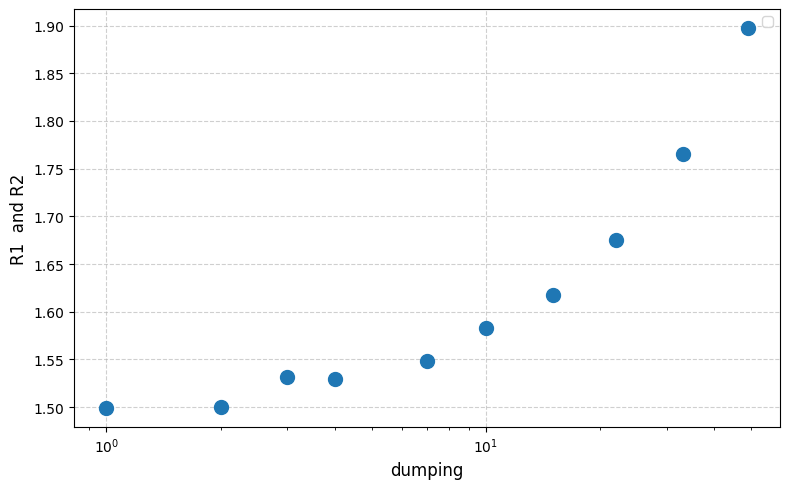

In [34]:
# scaled_T = all_temperatures * ref_temp

plt.figure(figsize=(8, 5))
plt.semilogx(np.int32(dumping), np.array(R1_at_target) * 1000, "o", markersize = 10)
# plt.semilogx(np.int32(dumping), np.array(R2_at_target) * 1000, "s", markersize = 10)

plt.xlabel("dumping", fontsize=12)
plt.ylabel("R1  and R2", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("relaxation_vs_dumping.png", dpi=300)
plt.show()

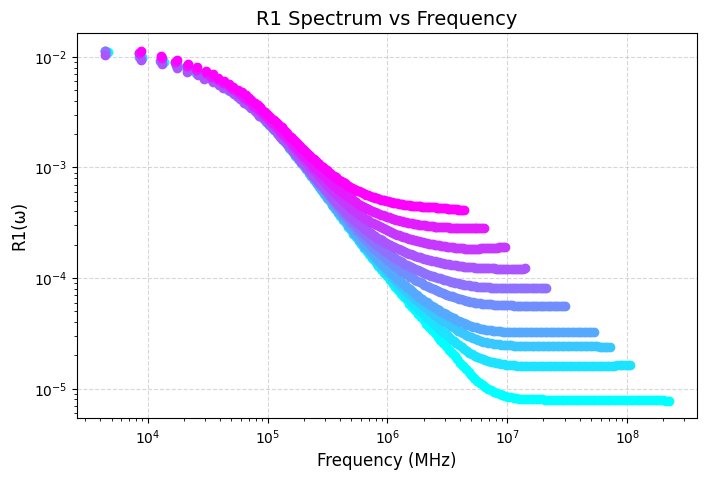

In [39]:
fig, ax = plt.subplots(figsize=(8, 5))

# Colormap and color assignment
cmap = plt.cm.cool
colors = cmap(np.linspace(0, 1, len(R1_spectra)))

# Plot each R1 spectrum
for d, color in zip(dumping, colors):
    f, R1 = np.loadtxt(f"d{d}/R1_vs_f.dat").T
    ax.loglog(f, R1, "o", color=color)

# Axis labels and title
ax.set_xlabel("Frequency (MHz)", fontsize=12)
ax.set_ylabel("R1(ω)", fontsize=12)
ax.set_title("R1 Spectrum vs Frequency", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.5)

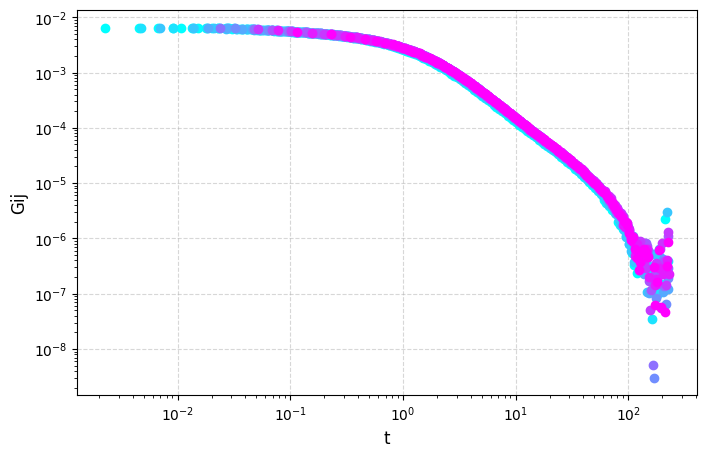

In [45]:
fig, ax = plt.subplots(figsize=(8, 5))

# Colormap and color assignment
cmap = plt.cm.cool
colors = cmap(np.linspace(0, 1, len(R1_spectra)))

# Plot each R1 spectrum
for d, color in zip(dumping, colors):
    t, Gij = np.loadtxt(f"d{d}/Gij_vs_t.dat").T
    ax.loglog(t, Gij, "o", color=color)

# Axis labels and title
ax.set_xlabel("t", fontsize=12)
ax.set_ylabel("Gij", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.5)